# Preparation

## Installing dependencies and *imgaug* library

In [133]:
!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio Shapely
!pip3 install git+https://github.com/aleju/imgaug

  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-mh2kkagf
  Stored in directory: /tmp/pip-ephem-wheel-cache-znv6_7je/wheels/9c/f6/aa/41dcf2f29cc1de1da4ad840ef5393514bead64ac9e644260ff
Successfully built imgaug


## Importing *imgaug* library to check installation

In [4]:
import imgaug
imgaug.__version__

'0.2.8'

# Dataset

## Installing dependencies and *pytorch* library

In [40]:
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1.post2-cp35-cp35m-linux_x86_64.whl
!pip3 install torchvision

## Importing *pytorch* library to check installation

In [24]:
import torch
torch.__version__

'1.0.1.post2'

## Creating Dataset class and Applying Augmentation

In [134]:
from torch.utils.data import Dataset
import os
import numpy as np
import cv2
import imgaug as ia
from imgaug import augmenters as iaa

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

class ImageClassificationDataset(Dataset):

    def __init__(self, images_dir, input_size):
        
        self.image_list=[]
        for root,dirs,files in os.walk('images',topdown=False):
            for filename in files:
                self.image_list.append(os.path.join(root,filename))
        
        self.sequential_augmenter = iaa.Sequential(
            [
                iaa.Fliplr(0.5), # horizontally flip 50% of all images
#                 iaa.Flipud(0.5),
                sometimes(iaa.CropAndPad(
                    percent=(-0.05, 0.1),
                    pad_mode=ia.ALL,
                    pad_cval=(128, 128)
                )),
                sometimes(iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                    rotate=(-15, 15), # rotate by -45 to +45 degrees
                    shear=(-10, 10), # shear by -16 to +16 degrees
                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    cval=(128, 128), # if mode is constant, use a cval between 0 and 255
                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                ))
            ],
            random_order=True
        )


    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):

        image_data = np.array(cv2.imread(self.image_list[idx]))
        images_aug = self.sequential_augmenter.augment_images(np.array([image_data]))
        
        #for showing purpose, append original and augmented image in one image to show differences
        stack = np.hstack((image_data, images_aug[0]))
        return stack


## Iterating over dataset and visualize augmented data

Left - Original, Right - Augmented


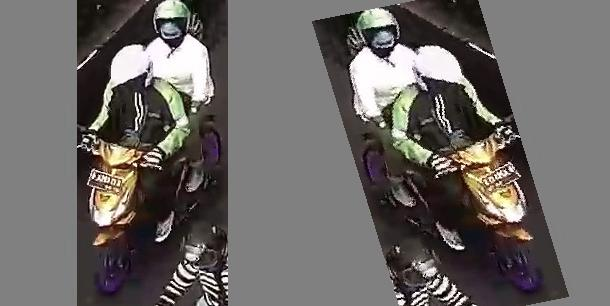

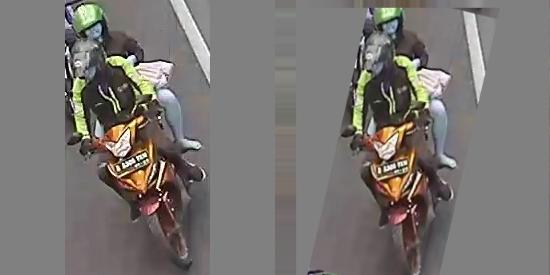

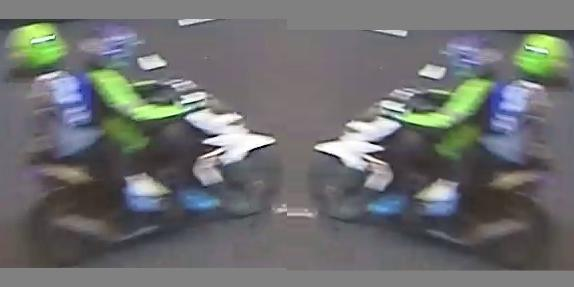

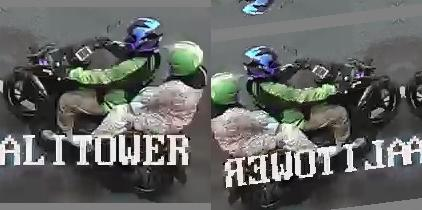

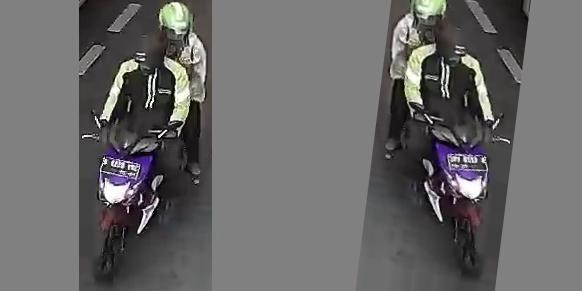

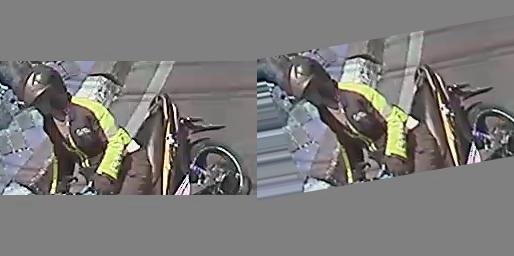

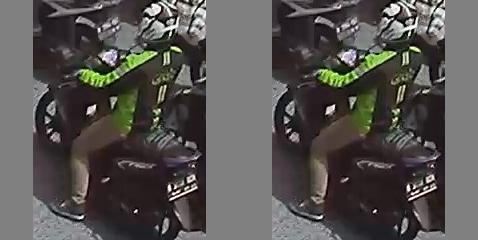

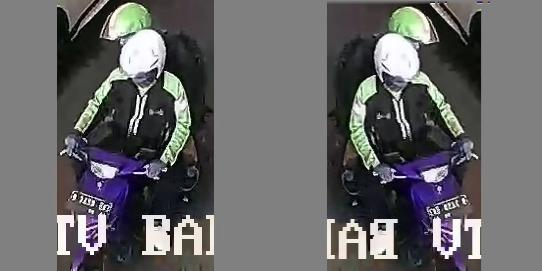

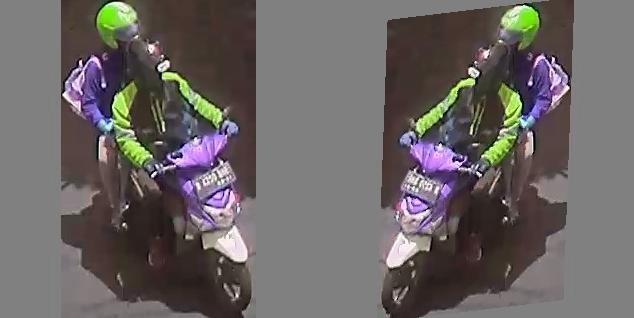

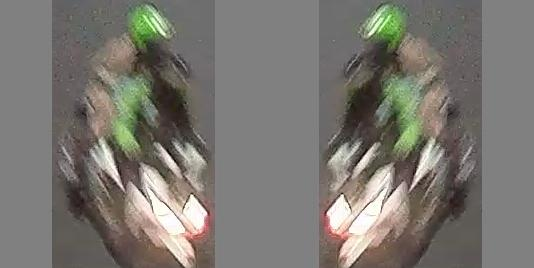

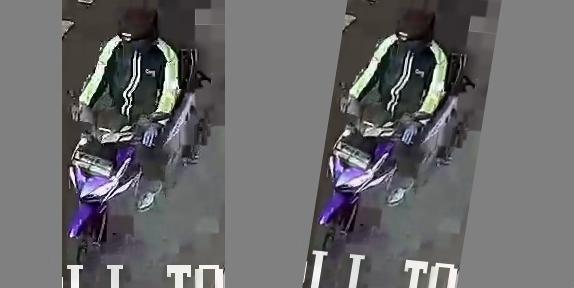

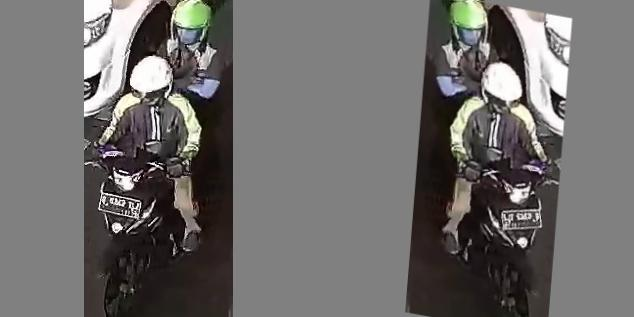

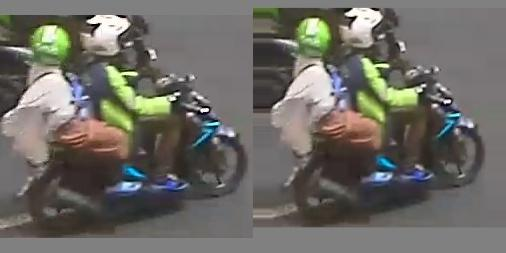

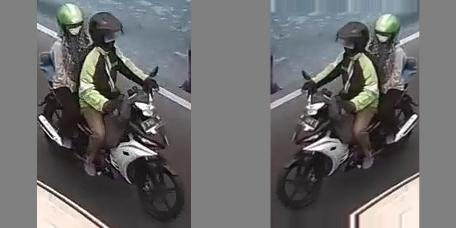

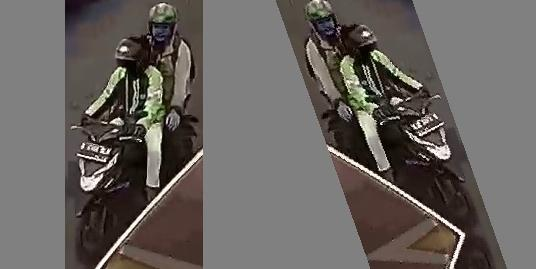

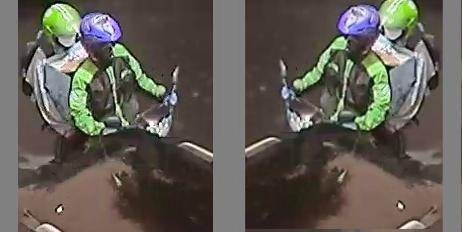

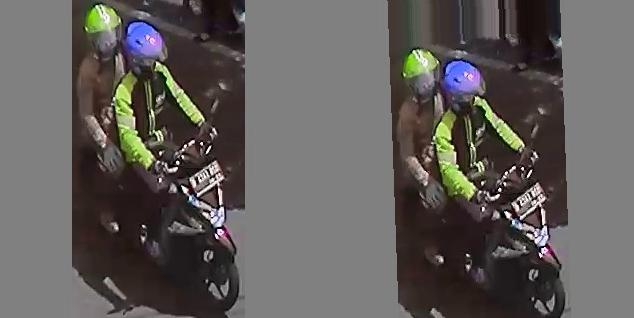

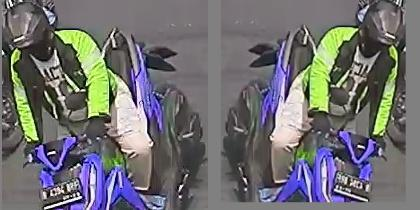

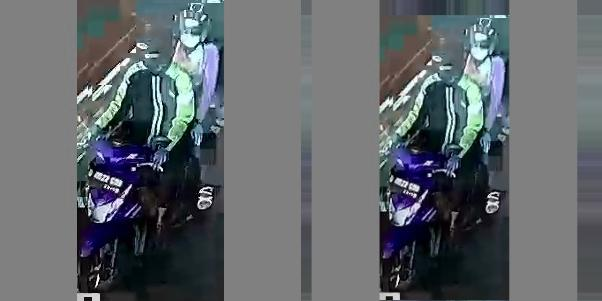

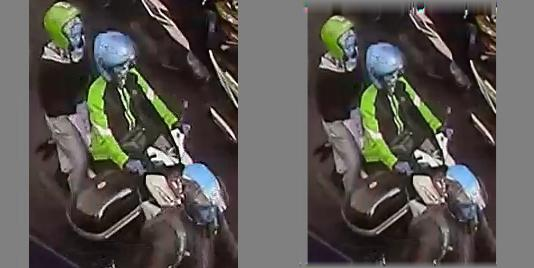

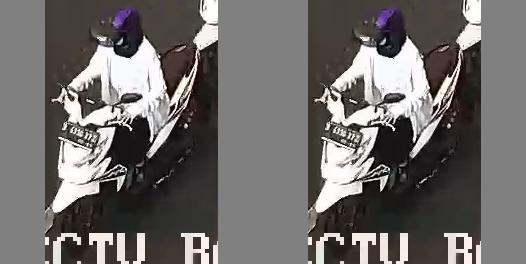

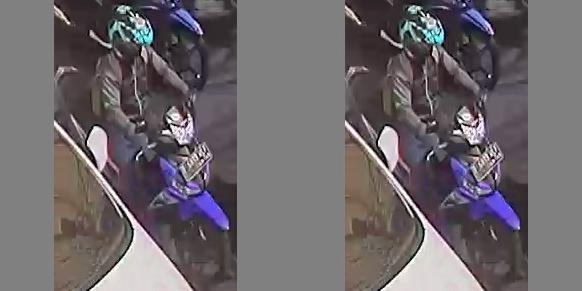

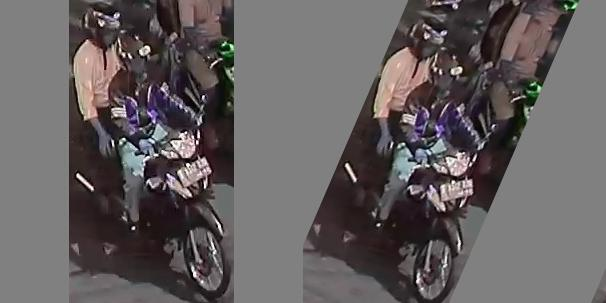

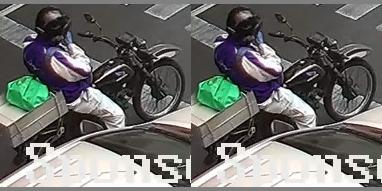

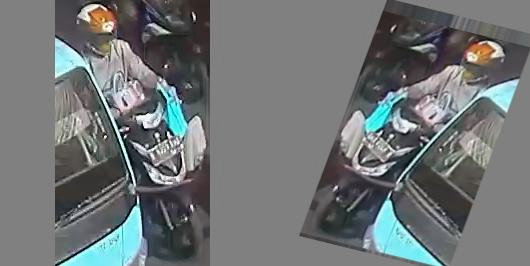

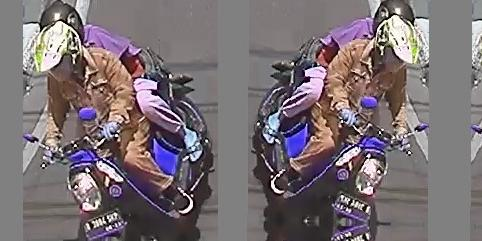

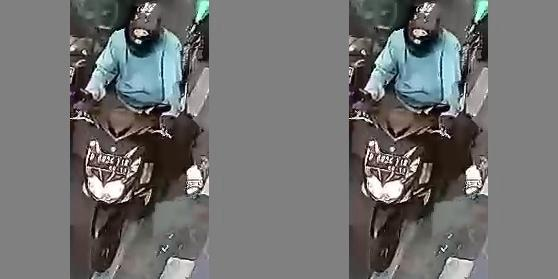

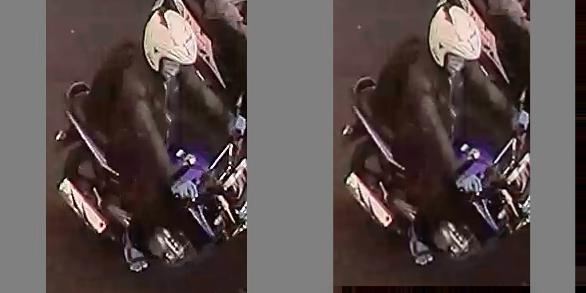

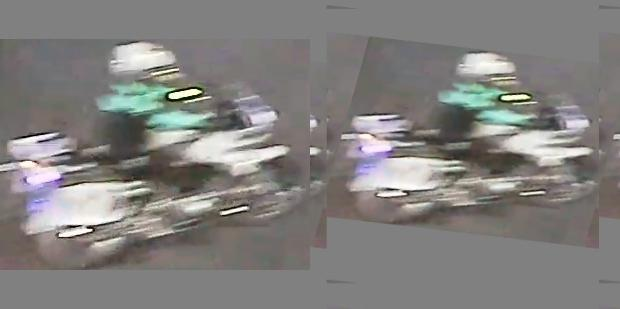

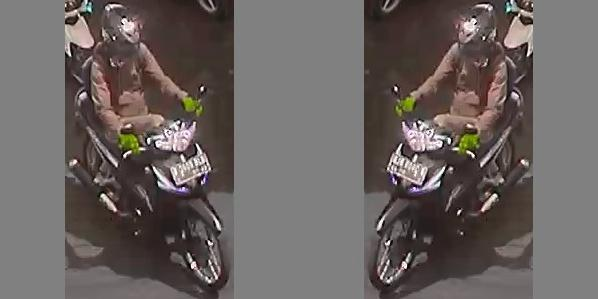

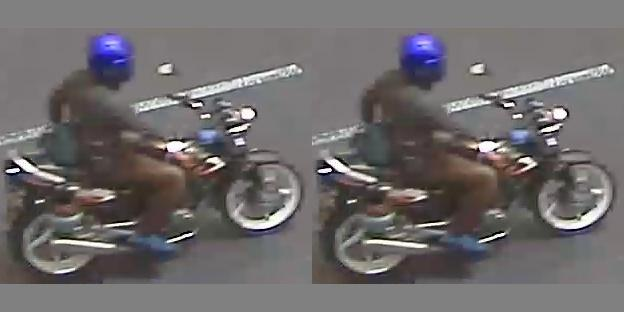

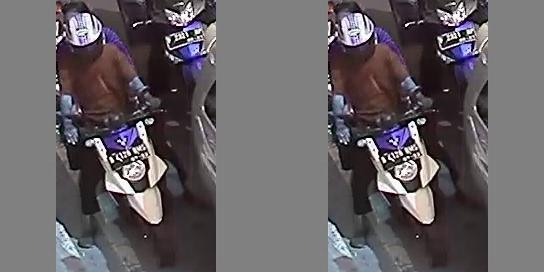

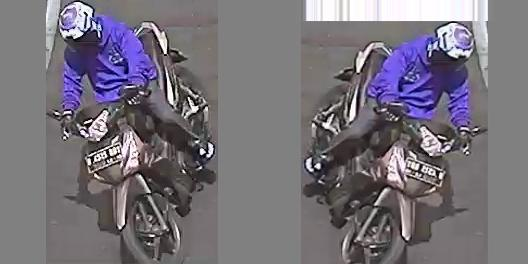

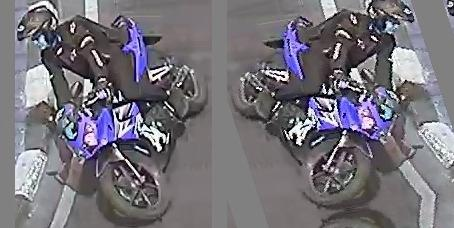

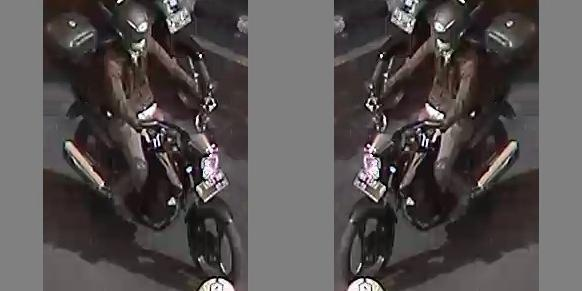

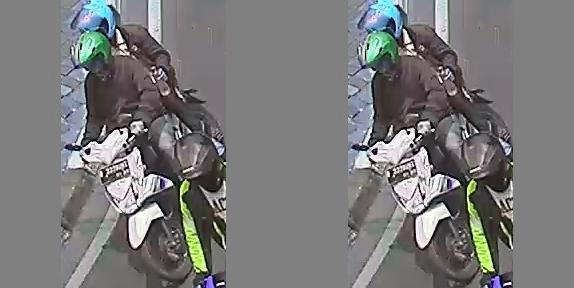

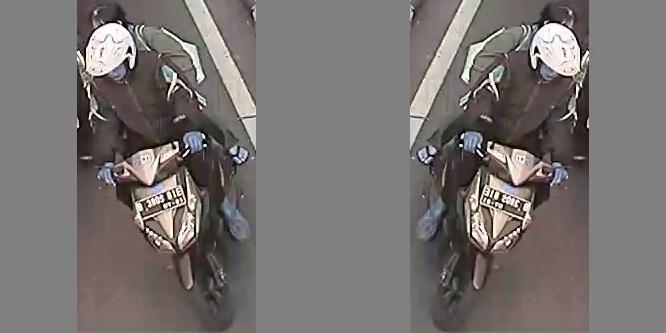

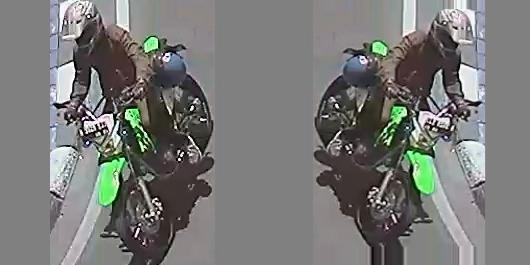

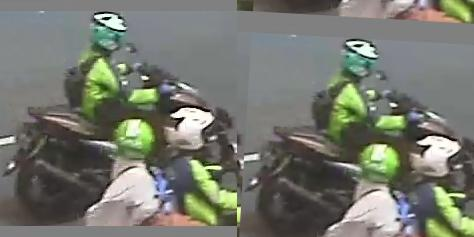

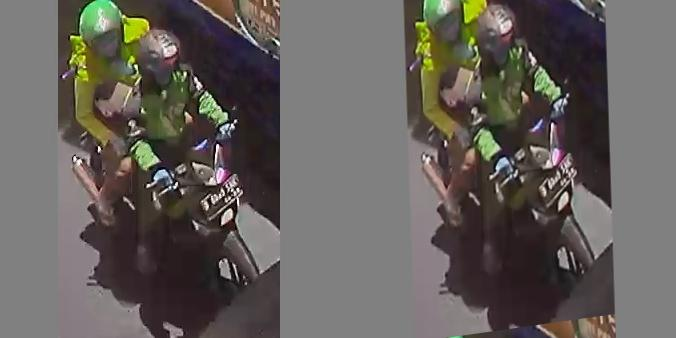

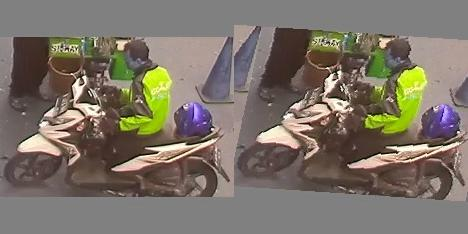

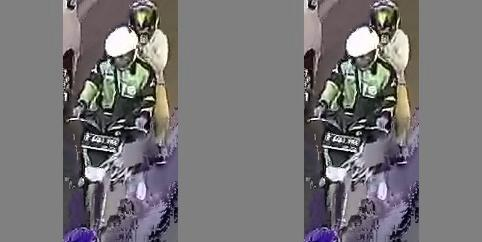

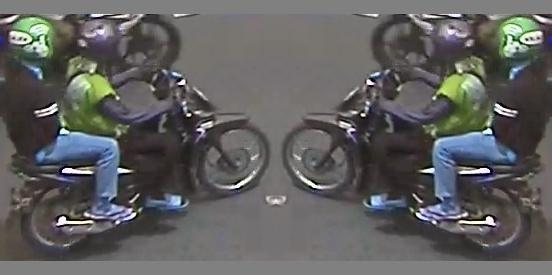

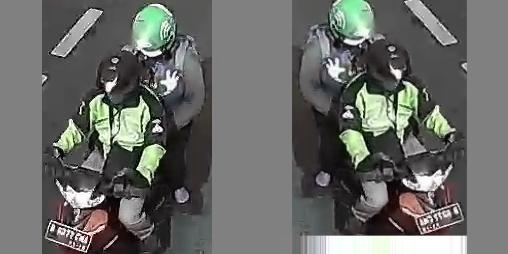

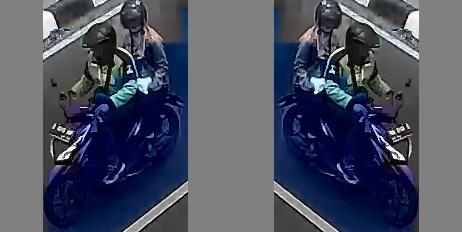

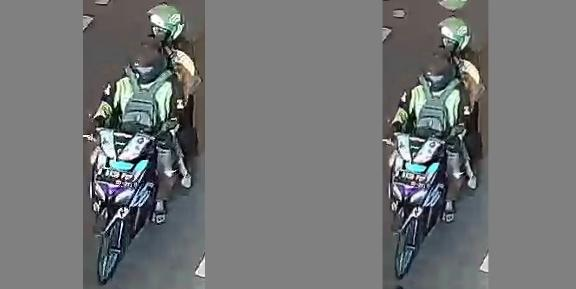

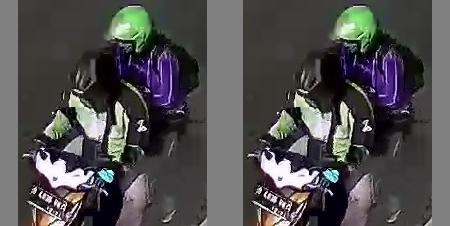

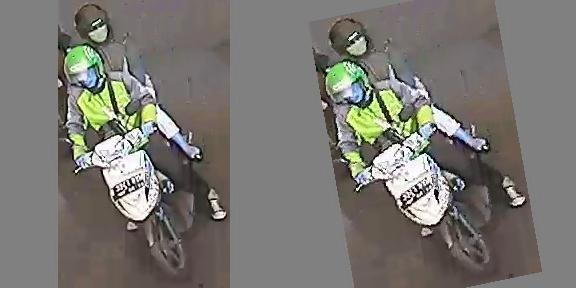

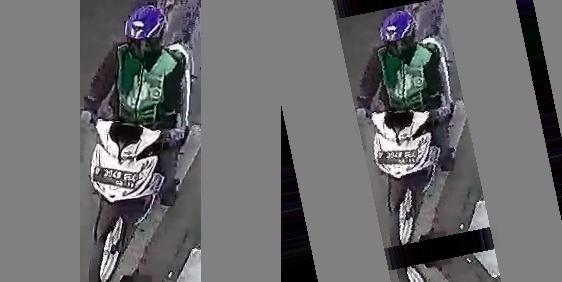

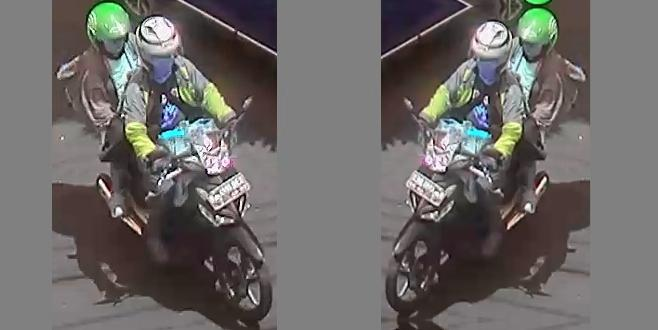

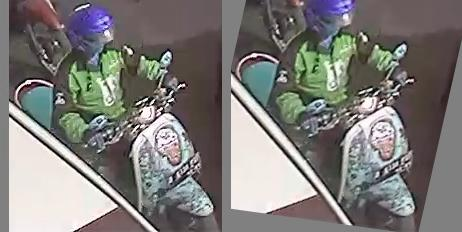

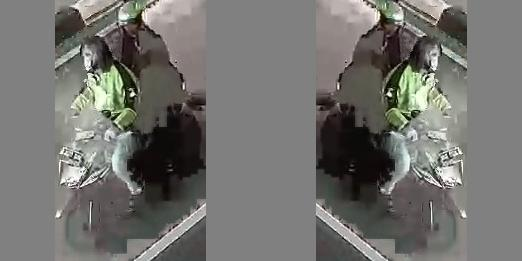

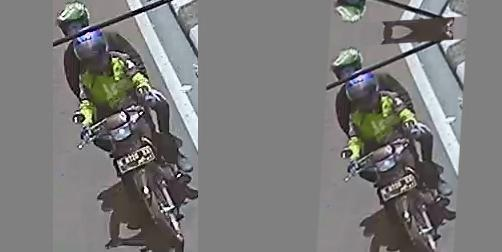

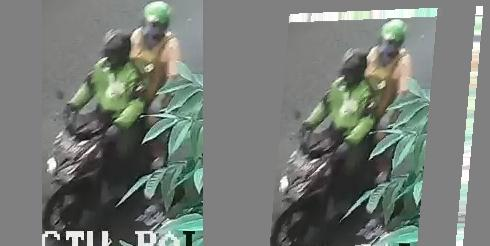

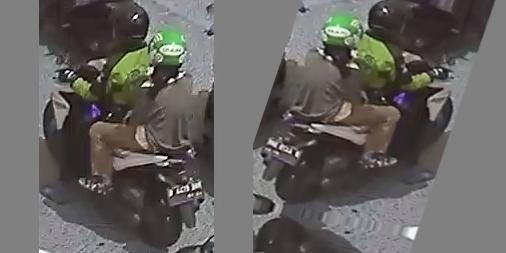

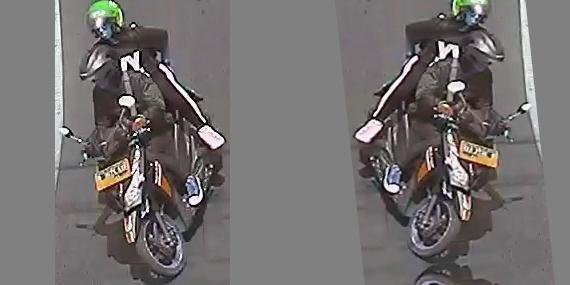

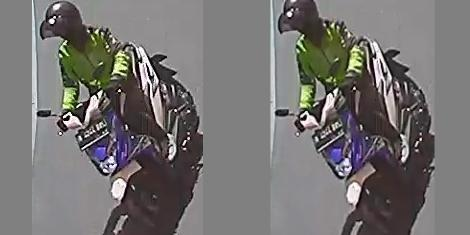

In [129]:
from IPython.display import clear_output, Image, display
from io import BytesIO
import PIL.Image

# function to show image in jupyter notebook
def showarray(img_data, fmt='jpeg'):
    img_data = np.uint8(np.clip(img_data, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(img_data).save(f, fmt)
    display(Image(data=f.getvalue()))

dataset=ImageClassificationDataset(images_dir='images',input_size=(224,224))
print('Left - Original, Right - Augmented')
for i in dataset:
    showarray(i)